In [33]:
import itertools
from tqdm import tqdm

import corr
import matplotlib.pyplot as plt
import torch_lddmm
import numpy as np
from skimage.metrics import structural_similarity as ssim

device = 'cuda:0'

In [2]:
frames = corr.load_example_experiment()
template_idx = corr.find_highest_correlation(frames)
template = frames[template_idx]
template = np.repeat(template[:, :, np.newaxis], 3, axis=2)
to_be_deformed = frames[0]
to_be_deformed = np.repeat(to_be_deformed[:, :, np.newaxis], 3, axis=2)

In [3]:
print(template.shape)
print(to_be_deformed.shape)

(258, 512, 3)
(258, 512, 3)


In [4]:
lddmm = torch_lddmm.LDDMM(template=to_be_deformed,
                          target=template,
                          a=5.0,
                          epsilon=4.0,
                          niter=200,
                          sigma=20,
                          sigmaR=40.0,
                          dx=[0.1,0.1,0.1],
                          dtype="float",
                          gpu_number=0,
                          update_epsilon=True)
# create object
lddmm.run() # run registration with these settings
deformed_template = lddmm.outputDeformedTemplate() # output deformed template as numpy array


Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid, 3 = rigid + scale)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      =

In [5]:
np.array(deformed_template[0])[:,:,1].shape

(258, 512)

In [6]:
(deformed_template2,_,_,_) = lddmm.applyThisTransform(to_be_deformed)

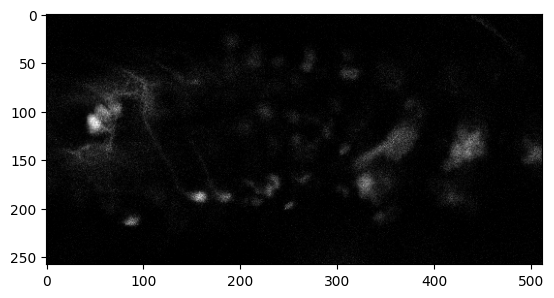

In [7]:
plt.imshow(deformed_template[0], cmap="gray")

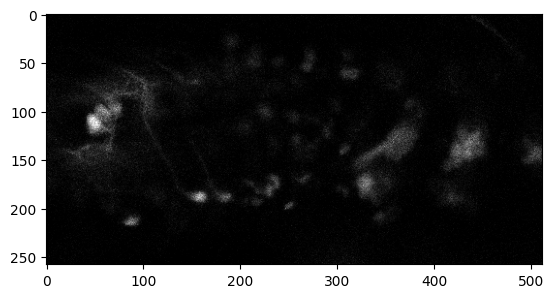

In [8]:
plt.imshow(to_be_deformed, cmap="gray")

In [39]:
deformed_template[0].shape

(258, 512, 3)

In [42]:
to_be_deformed.shape

(258, 512, 3)

In [32]:
np.array_equal(to_be_deformed, deformed_template[0])

False

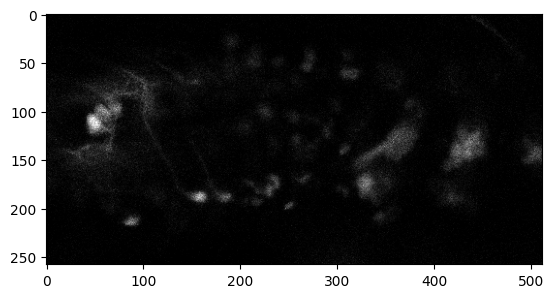

In [9]:
plt.imshow(deformed_template2[0].cpu(), cmap="gray")

In [15]:
print(frames[0].shape)
print(template[:,:,0].shape)
print(deformed_template[0].shape)

(258, 512)
(258, 512)
(258, 512, 3)


In [16]:
gray_template = template[:,:,0]
diffimg_before = np.abs(frames[0]-gray_template)
diffimg_after = np.abs(deformed_template[0][:,:,0] - gray_template)
diffimg_zero = np.abs(frames[0]-frames[0])

In [34]:
ssim(deformed_template[0][:,:,0], gray_template, data_range=gray_template.max() -
                                                            gray_template.min())

0.45506648259811233

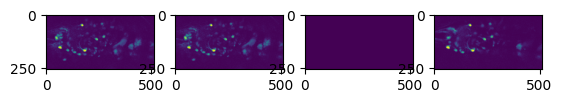

In [35]:
plt.figure()
plt.subplot(1,4,1)
plt.imshow(diffimg_after)
plt.subplot(1,4,2)
plt.imshow(diffimg_before)
plt.subplot(1,4,3)
plt.imshow(diffimg_zero)
plt.subplot(1,4,4)
plt.imshow(gray_template)

In [18]:
registered_frames = []
for idx in tqdm(range(10)):
    to_be_deformed = np.repeat(frames[idx][:, :, np.newaxis], 3, axis=2)
    print(to_be_deformed.shape)
    print(template.shape)
    lddmm = torch_lddmm.LDDMM(template=to_be_deformed,
                          target=template,
                          a=5.0,
                          epsilon=4.0,
                          niter=200,
                          sigma=20,
                          sigmaR=40.0,
                          dx=[0.1,0.1,0.1],
                          dtype="float",
                          gpu_number=0,
                          update_epsilon=True)
    lddmm.run()
    deformed_template = lddmm.outputDeformedTemplate()
    print(np.array(deformed_template).shape)
    registered_frames.append(np.array(deformed_template[0])[:,:,1])
    lddmm.delete()


  0%|          | 0/10 [00:00<?, ?it/s]

(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid, 3 = rigid + scale)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 =

 10%|█         | 1/10 [00:08<01:14,  8.33s/it]

iter: 195, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 196, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 197, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 198, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 199, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
Total elapsed runtime: 8.21 seconds.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
(1, 258, 512, 3)
(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (

 20%|██        | 2/10 [00:16<01:06,  8.36s/it]

(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid, 3 = rigid + scale)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 =

 30%|███       | 3/10 [00:25<00:58,  8.37s/it]

iter: 198, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 199, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
Total elapsed runtime: 8.26 seconds.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
(1, 258, 512, 3)
(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step,

 40%|████      | 4/10 [00:33<00:49,  8.32s/it]

iter: 199, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
Total elapsed runtime: 8.14 seconds.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
(1, 258, 512, 3)
(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear regist

 50%|█████     | 5/10 [00:41<00:41,  8.30s/it]

iter: 199, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
Total elapsed runtime: 8.16 seconds.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
(1, 258, 512, 3)
(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear regist

 60%|██████    | 6/10 [00:49<00:33,  8.27s/it]

iter: 197, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 198, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 199, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
Total elapsed runtime: 8.09 seconds.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
(1, 258, 512, 3)
(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time st

 70%|███████   | 7/10 [00:58<00:24,  8.25s/it]

(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid, 3 = rigid + scale)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 =

 80%|████████  | 8/10 [01:06<00:16,  8.24s/it]

iter: 198, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 199, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
Total elapsed runtime: 8.10 seconds.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
(1, 258, 512, 3)
(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step,

 90%|█████████ | 9/10 [01:14<00:08,  8.22s/it]

iter: 196, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 197, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 198, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
iter: 199, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
Total elapsed runtime: 8.07 seconds.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
(1, 258, 512, 3)
(258, 512, 3)
(258, 512, 3)

Current parameters:
>    a               = 5.0 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 200 (number of iterations)
>    epsilon         = 4.0 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 20 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 40.0 (regularization term coef

100%|██████████| 10/10 [01:22<00:00,  8.25s/it]

iter: 199, E= 0.004, ER= 0.000, EM= 0.004, epd= 4.000, time= 0.04s.
Total elapsed runtime: 8.03 seconds.
Parameter 'epsilonL' changed to '1e-07'.
Parameter 'epsilonT' changed to '2e-05'.
(1, 258, 512, 3)


In [20]:
registered_frames[0].shape
template[:,:,1].shape

(258, 512)

In [21]:
ssims = corr.evaluate(registered_frames, template[:,:,1])

In [22]:
np.mean(ssims)

0.4515713320632687

In [29]:
def grid_search() -> dict:
    """Search for any parameter combination not resulting in an empty image."""
    min_param = 1
    max_param = 10
    step_size = 1
    parameter_list = ["a", "epsilon", "sigma", "sigmaR"]

    values = list(range(min_param,max_param+1,step_size))
    combinations = list(itertools.product(values, repeat=len(parameter_list)))
    for combo in combinations:
        params = dict(zip(parameter_list, combo, strict=False))
        lddmm = torch_lddmm.LDDMM(template=to_be_deformed, target=template,
                                  a=params["a"],
                      epsilon=params["epsilon"], sigma=params["sigma"],
                        sigmaR=params["sigmaR"], dx=[0.1,0.1,0.1], dtype="float")
        lddmm.run()
        deformed_template = lddmm.outputDeformedTemplate()
        if np.array_equal(deformed_template, template):
            print("something has changed!")
            break
    return params

In [30]:
good_params = grid_search()


Current parameters:
>    a               = 1 (smoothing kernel, a*(pixel_size))
>    p               = 2 (smoothing kernel power, p*2)
>    niter           = 100 (number of iterations)
>    epsilon         = 1 (gradient descent step size)
>    epsilonL        = 1e-07 (gradient descent step size, affine)
>    epsilonT        = 2e-05 (gradient descent step size, translation)
>    minbeta         = 0.0001 (smallest multiple of epsilon)
>    sigma           = 1 (matching term coefficient (0.5/sigma**2))
>    sigmaR          = 1 (regularization term coefficient (0.5/sigmaR**2))
>    nt              = 5 (number of time steps in velocity field)
>    do_lddmm        = 1 (perform LDDMM step, 0 = no, 1 = yes)
>    do_affine       = 0 (interleave linear registration: 0 = no, 1 = affine, 2 = rigid, 3 = rigid + scale)
>    checkaffinestep = 0 (evaluate linear matching energy: 0 = no, 1 = yes)
>    im_norm_ms      = 0 (normalize image by mean and std: 0 = no, 1 = yes)
>    gpu_number      = 0 (inde

KeyboardInterrupt: 

In [19]:
lddmm.delete()